# Robust regression assignment
## Yoav Ram

In [2]:
import urllib.request
import os
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize
import emcee
from corner import corner
import seaborn as sns
sns.set_context('talk')
red, blue, green = sns.color_palette('Set1', 3)

Consider the following dataset.

In [3]:
###
df = pd.read_csv('../data/outliers.csv')
df.head()

,x,y
0,0,23.715417
1,3,64.343713
2,9,33.164727
3,14,32.338875
4,15,38.264633


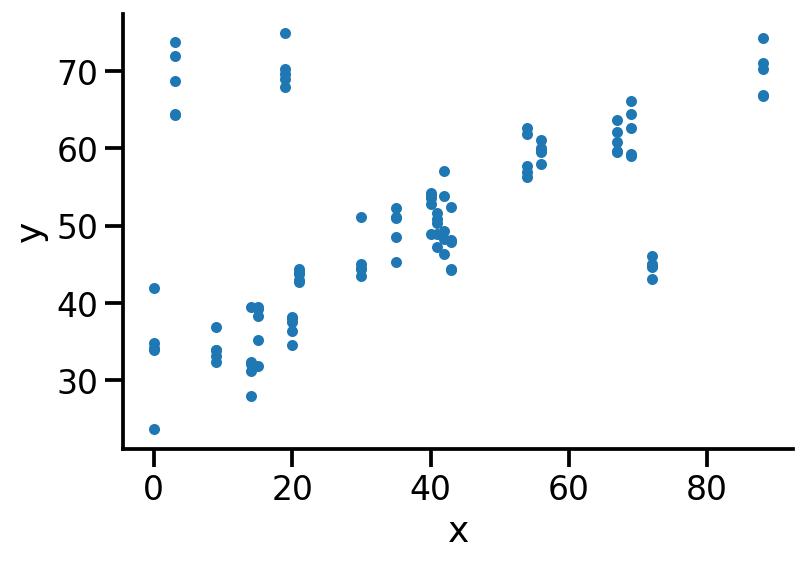

In [5]:
x = df['x'].values
y = df['y'].values
plt.plot(x, y, '.')
plt.xlabel('x')
plt.ylabel('y')
sns.despine()

There are several `y` measurements for each `x` value. 
We therefore compute the mean and standard deviation for `y` at each `x` value, and assign the mean back to `y` and the standard deviation to `e`.

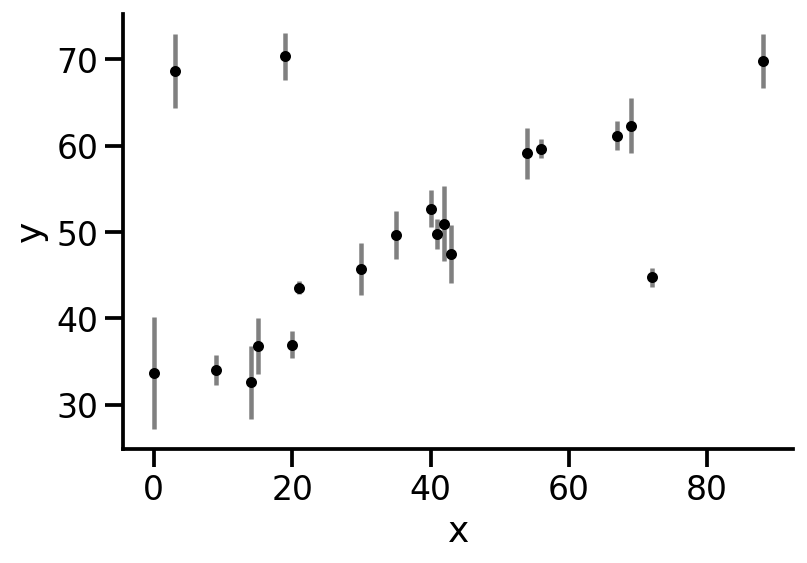

In [6]:
e = df.groupby('x')['y'].std(ddof=1).values
y = df.groupby('x')['y'].mean().values
x = np.unique(x)

def plot_data():
    plt.errorbar(x, y, yerr=e, fmt='.k', ecolor='gray')
    plt.xlabel('x')
    plt.ylabel('y')
    sns.despine()
    
plot_data()

We can observe something similar to a linear relationship between `x` and `y`, but with some outliers, especially in the top left corner.

We would like to find a linear model that fits the data. 

The straightforward approach is that of the normal linear model:

$$
\hat{y}_i = a x_i + b \\
y_i \sim N(\hat{y}_i, e_i) \\
$$

Here, we use the estimates `e` for the standard deviation; this can provide a better model fit then estimating one parameter for all `x` values, especially when some of the points are outliers.

**Find the parameters $\theta=(a, b)$ that minimize the negative log-likelihood**, or the loss function, by implementing the loss function (`loss_norm`) and minimizing it.
You can use a function from `scipy.optimize` or do gradient descent, whatever you'd like.

Remember that maximizing the likelihood = maximizing the log-likelihood = minimizing the negative log-likelihood = miniziming the loss function.

*Note* you should use `e` to standardize the residuals: look at the role of σ in the original probability density function of the normal distribution.

In [ ]:
def loss_norm(θ, x, y, e):  
    ### your code here
    
    
    
    
θ_guess = 35, 0.75 
print(loss_norm(θ_guess, x, y, e)) 
# prints: 14639722.031479657

In [8]:
θ_norm = # your code here


print("Nomral linear model:\n a={:.2f}, b={:.2f}".format(*θ_norm)) ###

Optimization terminated successfully.
         Current function value: 385.354818
         Iterations: 88
         Function evaluations: 167
Nomral linear model:
 a=0.23, b=39.47


We plot the result:

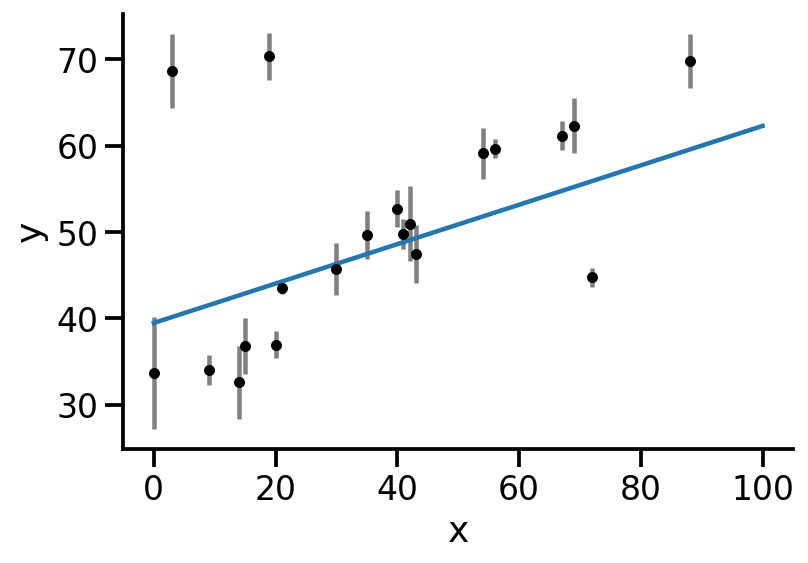

In [95]:
a, b = θ_norm
x_range = np.linspace(0, 100)

plot_data()
plt.plot(x_range, a * x_range + b, '-');

It's clear on examination that the outliers are exerting a disproportionate influence on the model fit.
This is due to the nature of the squared loss function.
If you have a single outlier that is 10 standard deviations away from the model lines its contribution to the loss will out-weigh that of 25 points which are 2 standard deviations away!

## Huber linear model for outlier correction

The variety of possible loss functions is quite literally infinite, but one relatively well-motivated option is the [Huber loss](http://en.wikipedia.org/wiki/Huber_loss_function). The Huber loss defines a critical value at which the loss curve transitions from quadratic to linear.
$$
f_{\delta}(x)=\left\{\begin{array}{ll}
\frac{1}{2} x^{2} & \text { for }|x| \leq \delta \\
\delta\left(|x|-\frac{1}{2} \delta\right), & \text { otherwise }
\end{array}\right.
$$

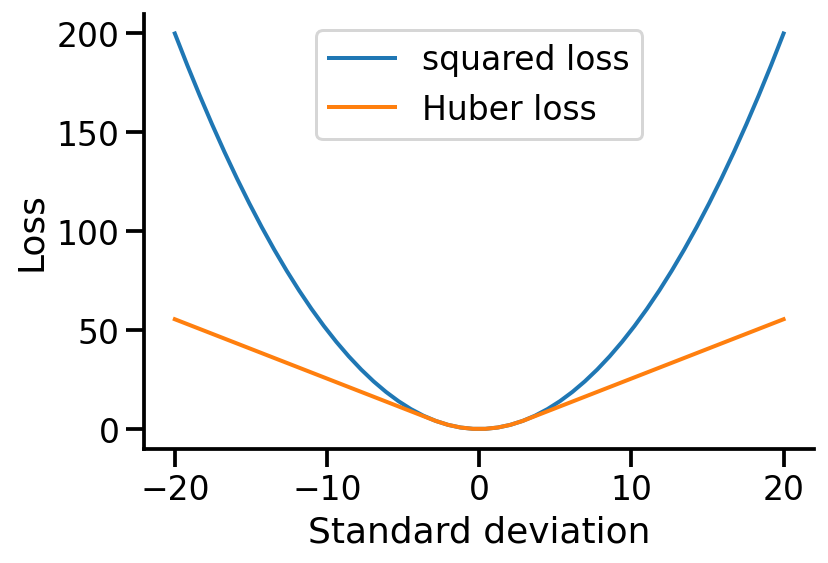

In [10]:
def huber(x, δ=3):
    return (
        (abs(x) < δ) * 0.5 * x * x +
        (abs(x) >= δ) * -δ * (0.5 * δ - abs(x)))

t = np.linspace(-20, 20)
plt.plot(t, 0.5 * t * t, label="squared loss", lw=2)
plt.plot(t, huber(t), label="Huber loss", lw=2)
plt.legend()
plt.xlabel('Standard deviation')
plt.ylabel('Loss')
sns.despine()

**Implement the `loss_huber` loss function**, which is similar to the nagative log-likelihood we implemented for the normal model, except that it uses the `huber` function instead of taking the square of the residuals.

In [ ]:
def loss_huber(θ, x, y, e, δ=3): ###
    ### your code here
    
    

print(loss_huber(θ_guess, x, y, e)) ###
# prints 37893.56096703832

**Find the `a` and `b` values that minizime `loss_huber`.**

In [13]:
θ_huber = # your code here

print("Huber linear model:\n a={:.2f}, b={:.2f}".format(*θ_huber)) ###

Optimization terminated successfully.
         Current function value: 109.172430
         Iterations: 81
         Function evaluations: 158
Huber linear model:
 a=0.39, b=34.73


Now we plot the data with the two model fits. 

The code below plots the data, the normal, and Huber models.

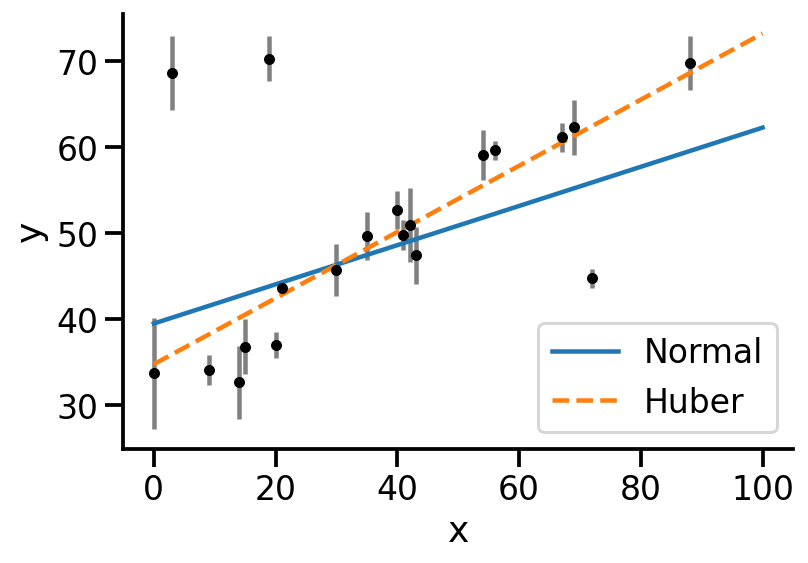

In [14]:
x_range = np.linspace(0, 100) 

plot_data() 
a, b = θ_norm
plt.plot(x_range, a * x_range + b, '-', label='Normal')
a, b = θ_huber
plt.plot(x_range, a * x_range + b, '--', label='Huber')
plt.legend();

By eye, this seems to have worked as desired: the fit is much closer to our intuition!

However a Bayesian might point out that the motivation for this new loss function is a bit suspect: as we showed, the squared-loss can be straightforwardly derived from a Gaussian likelihood. The Huber loss seems a bit *ad hoc*: where does it come from? How should we decide what value of $\delta$ to use? Is there any good motivation for using a linear loss on outliers, or should we simply remove them instead? How might this choice affect our resulting model?

## Bayesian linear model: nuisance parameters

The Bayesian approach to accounting for outliers generally involves *modifying the model*.
We propose a more complex model that is a mixture between a signal and background noise:

$$
\hat{y}_i = a x_i + b
\\
y_i \sim \begin{cases}{
    N(\hat{y}_i, e_i) , \quad g_i=1 \\
    N(\hat{y}_i, \sigma), \quad g_i=0 
}\end{cases}
$$

Here, $g_i$ are _nuisance parameters_ that determines if the data point $y_i$ is drawn from the signal distribtion $N(\hat{y}_i, e_i)$, in which the variance is estimated by $e_i^2$, or from the noise distribution $N(\hat{y}_i, \sigma) $, in which the variance is $\sigma^2$ for some relatively large value, say $\sigma=50$.

The likelihood function is therefore:
$$
\mathcal{L}(\theta \mid x, y) = \prod_{i=1}^{n}{\Big[g_i P(y_i \mid a, b, x, e) + (1-g_i) P(y_i \mid a, b, x, \sigma)\Big]}
$$
where $P(y_i \mid a, b, x_i, e_i)$ is the probability density function of $N(ax_i+b, e_i^2)$.

In effect, we will estimate the probability $g_i$ that $y_i$ is _not an outlier_, in the Bayesian sense of probability: belief or confidence. So we are doing a regression problem while performing an auxiliary classification problem.

Our model is much more complex now: it has 22 parameters rather than 2, but the majority of these are $g_i$ which can be considered _nuisance parameters_, and can be marginalized-out in the end (see below).

To actually compute this, we'll start by defining functions describing our prior, our likelihood function, and our posterior.

$\theta$ will be an array of length $2 + N$, where $N$ is the number of points, $a=\theta_0$ is the slope, $b=\theta_1$ is the intercept, and $g_i=\theta_{2+i}$ is the weight of point $i$.

**Implement the log-prior function**. It can be uniform, but consider the bounds you desire for $a$, $b$, and $g_i$.

In [17]:
def log_prior(θ): 
    ### your code here
    
    
    

The log-likelihood function is given.

Note: if `g` is 0 or 1, then taking the log of `g` or `1-g` will produce negative infinity. Therefore, we add `ϵ` to `g` and to `1-g` to avoid this numerical issue.

Think: what is `np.logaddexp` and why is it used here? 

In [18]:
def log_likelihood(θ, x, y, e, σ=50, ϵ=1e-16):
    # linear model params
    a, b = θ[:2]
    # nuisance params
    g = θ[2:]
        
    yhat = a * x + b
    resid = y - yhat    
    resid2 = resid * resid
    logL1 = np.log(g + ϵ) - 0.5 * np.log(2 * np.pi * e * e) - 0.5 * resid2 / (e * e)
    logL2 = np.log(1 - g + ϵ) - 0.5 * np.log(2 * np.pi * σ * σ) - 0.5 * resid2 / (σ * σ)
    return np.logaddexp(logL1, logL2).sum()

In [19]:
def log_posterior(θ, x, y, e):
    logpri = log_prior(θ)
    if np.isinf(logpri): return logpri
    return logpri + log_likelihood(θ, x, y, e)

**Finish seting up the model for _emcee_.**

In [20]:
ndim =   # number of parameters in the model
nwalkers =  # number of MCMC walkers
nsteps =   # number of MCMC steps to take
nburn =   # burn-in period to let chains stabilize

# set theta near the maximum likelihood, with 
guesses = np.zeros((nwalkers, ndim))
# θ guess drawn around results of normal linear model
guesses[:, :2] = np.random.normal(θ_norm, 1, (nwalkers, 2))
# nuisance params guesses are around 50:50
guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

var_names = ['a', 'b'] + ['g{}'.format(i - 2) for i in range(len(x))] ###

Now we run the sampler.

*Note*: this step might take a few minutes to run.

In [21]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e])
sampler.run_mcmc(guesses, nsteps);

# sampler.chain.shape = (nwalkers, nsteps, ndim)

Lets plot the traces:

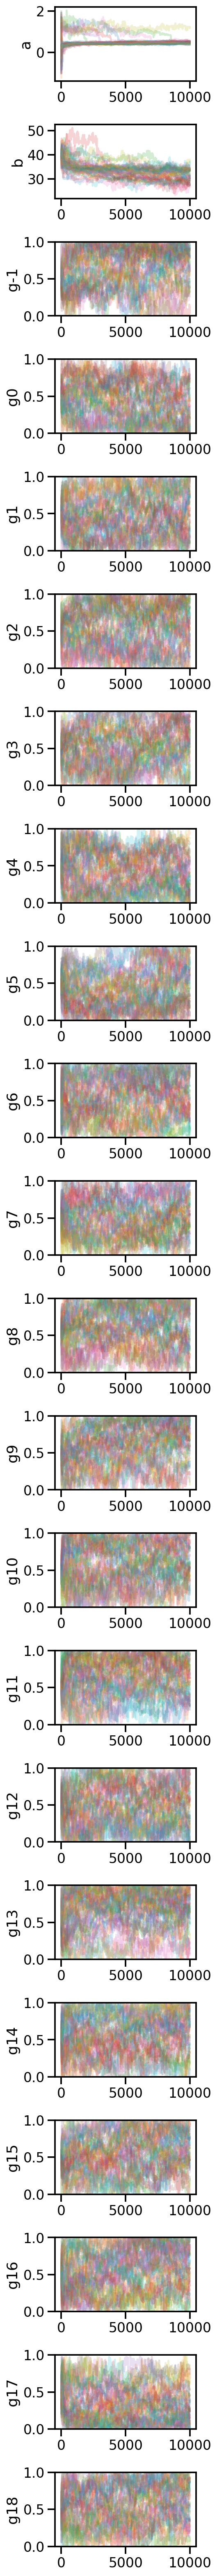

In [22]:
fig, axes = plt.subplots(ndim, 1, figsize=(4, ndim*2))

for i, ax in enumerate(axes):
    ax.plot(sampler.chain[:, :, i].T, alpha=0.2)
    ax.set_ylabel(var_names[i])
    if i >= 2: 
        ax.set_ylabel('g{}'.format(i-3))
        ax.set_ylim(0, 1)
fig.tight_layout()

We can exploit a very nice property of the Markov chains.
Because their distribution models the posterior, we can integrate out (i.e. marginalize) over nuisance parameters simply by ignoring them! That's really cool because integrating the posterior is hard. But MCMC is effectively a method for integrating the posterior.

So we can estimate $a$ and $b$ by simply taking their average values over the posterior samples.

In [23]:
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
θ_bayes = sample[:, :2].mean(axis=0)

print("Huber model:\n a={:.2f}, b={:.2f}".format(*θ_huber))
print("Bayesian mixture model:\n a={:.2f}, b={:.2f}".format(*θ_bayes))

Huber model:
 a=0.39, b=34.73
Bayesian mixture model:
 a=0.49, b=32.23


Plotting the marginal and joint posterior distributions of $a$ and $b$, we also mark the Huber estimate in blue and the Bayesian estimate in green.

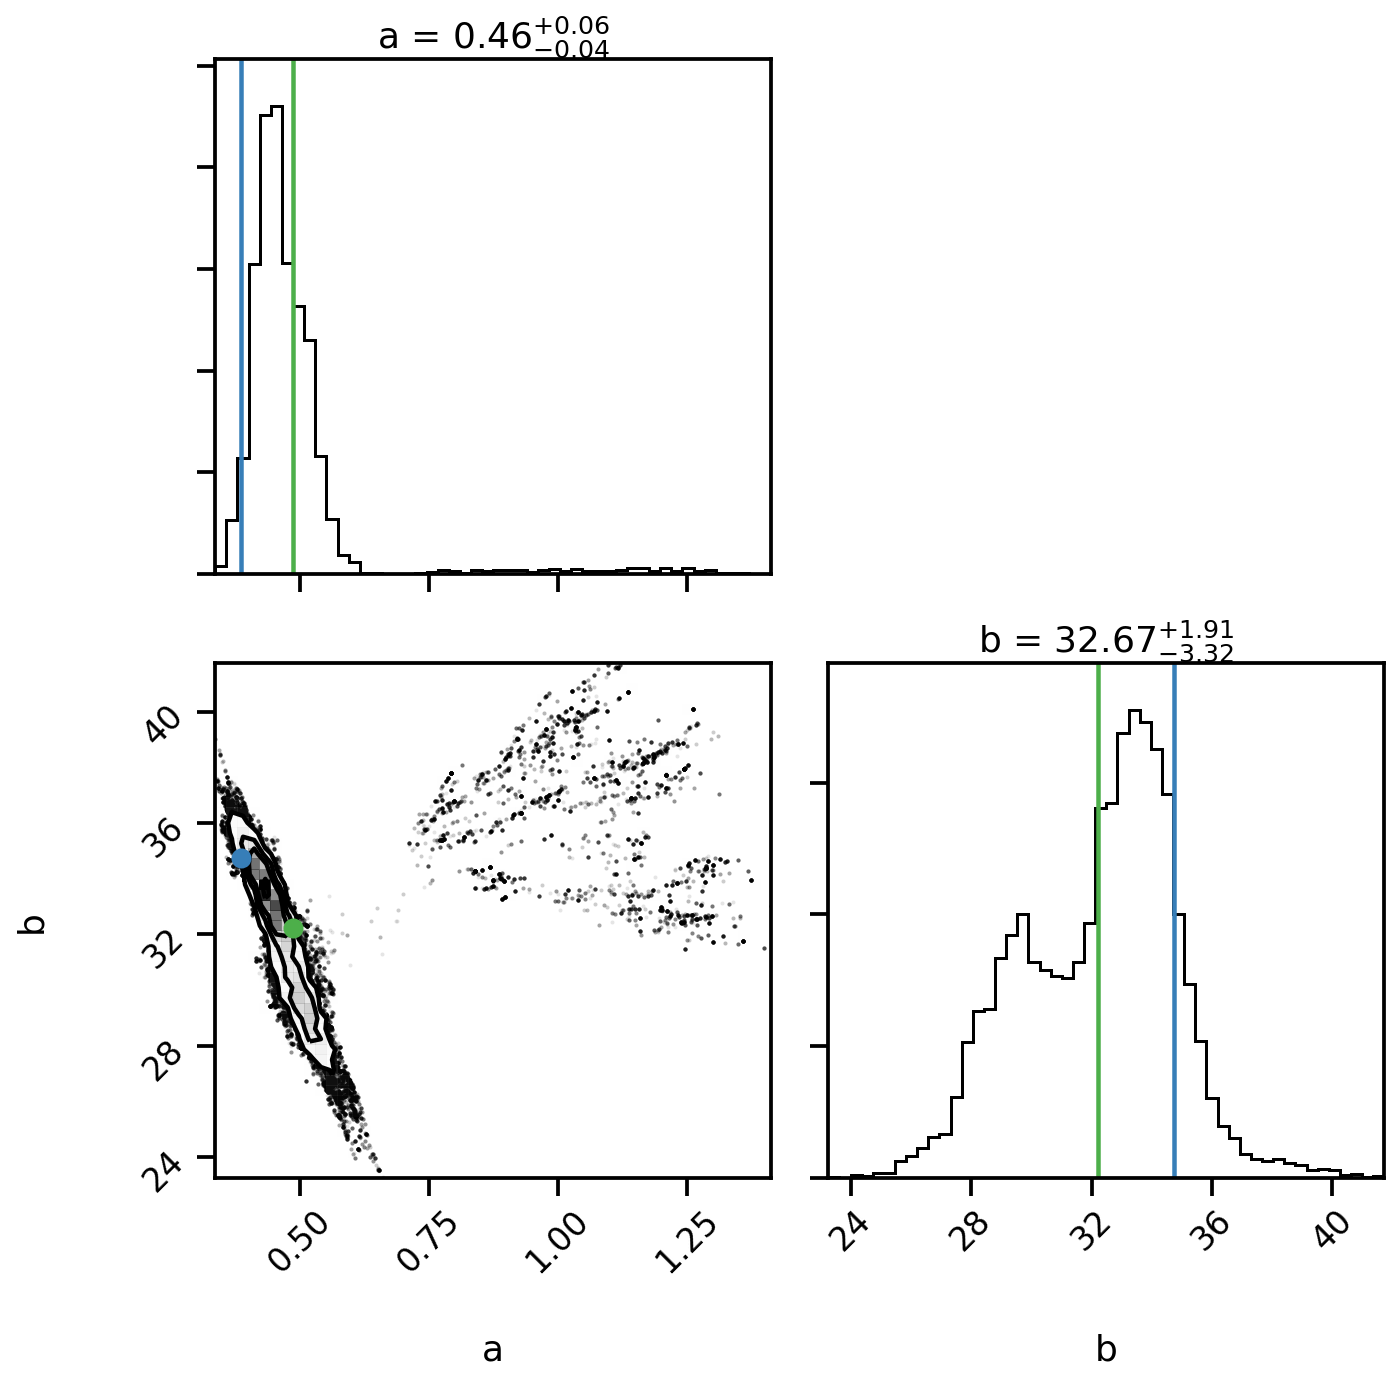

In [26]:
cor = corner(
    sample[:,:2], 
    bins=50,
    labels=var_names[:2],
    show_titles=True,
)
for θ_, color in zip([θ_huber, θ_bayes], [blue, green]):
    a_, b_ = θ_
    cor.axes[0].axvline(a_, color=color)
    cor.axes[3].axvline(b_, color=color)
    cor.axes[2].plot(a_, b_, marker='o', color=color)
cor.set_size_inches(10, 10)
cor.tight_layout()

If we focus on the joint distribution around the main density we see that there is some correlation between $a$ and $b$.

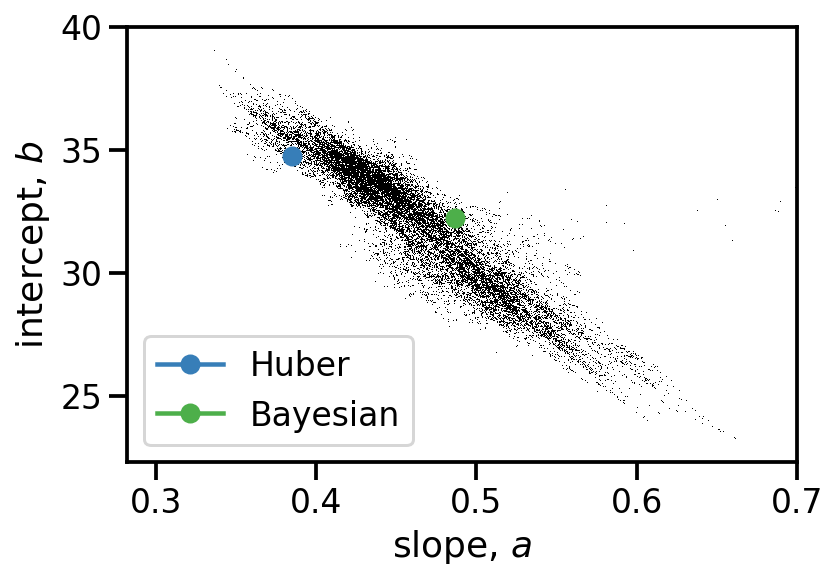

In [27]:
plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=1)
for θ_, color, label in zip([θ_huber, θ_bayes], [blue, green], ['Huber', 'Bayesian']):
    a_, b_ = θ_
    plt.plot(a_, b_, marker='o', color=color, label=label)
plt.xlim(None, 0.7)
plt.ylim(None, 40)
plt.ylabel('intercept, $b$')
plt.xlabel('slope, $a$')
plt.legend();

We can predict which data points are outliers using the estimates for $g_i$.

In the cell below, **choose a threshold value** to decide what value of $g$ corresponds to an oulier and what value corresponds to a inlier.

In [ ]:
thershold =    # Choose a thershold!

g = np.mean(sample[:, 2:], 0) # estimate g_i by taking mean over posterior
outliers = (g < thershold) # classify outliers

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(x))[outliers], g[outliers], color=red)
plt.bar(np.arange(len(x))[~outliers], g[~outliers], color=blue)
plt.axhline(thershold, color='k', ls='--')
plt.ylim(0, 1)
plt.xticks(range(0, len(x), 2))
plt.xlabel('Data point, $i$')
plt.ylabel('Outlier probability, $g_i$');

Finally, we can see how the different models compare in terms of model fitting.

Importantly, we can mark the predicted outliers: data points for which $g_i$ is below some threshold.

In [ ]:
plt.plot(x, y, 'o')
plt.plot(x_range, θ_norm[1] + θ_norm[0] * x_range, ls='--', alpha=0.85, label='Normal', color='k')
plt.plot(x_range, θ_huber[1] + θ_huber[0] * x_range, ls='--', alpha=0.85, label='Huber', color=blue)
plt.plot(x_range, θ_bayes[1] + θ_bayes[0] * x_range, label='Bayesian', color=green)
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec=red)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(1, 0.85))
plt.title('Normal vs Huber vs Bayesian linear models')
sns.despine()

Amazingly (?), the Bayesian model produces a much better fit and also identifies as outliers mostly the points that we would identify by the "eye test".

**End of assignment**